# Predicting House Prices with Gradient Boosting

<b>author: Neil Kutty<br>

The data for this project has 80 native features and an outcome variable for the dollar amount a house sold for.  Prior research (see: De Cock, Dean, Journal of Statistics Education Volume 19, Number 3(2011)  https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) conducted on this dataset has shown low accuracy ~70\% for OLS Linear models. We seek to improve on this prior research by using Gradient Boosting, Spectral Clustering for feature derivation, and Principal Component Analysis for feature selection.\\

The features are a mix of categorical and continuous variables. Around 7000 values are NA out of a total of approximately 111,300 values. We forego utilizing dummy variables for this iteration in order to perfectly match the test set’s feature count.\\

Our best model is through gradient boosting with 250 estimators resulting in a 91.58\% accuracy rate when using the top 75 features including derived features obtained through unsupervised learning and then ranked by PCA. 


In [1]:
%matplotlib inline

import datetime
now = datetime.datetime.now()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import linear_model
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import os

np.random.seed(10)

<h4> Data Description </h4>
Source: https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt<br>
NAME: AmesHousing.txt<br>
TYPE: Population<br>
SIZE: 2930 observations, 82 variables<br>
ARTICLE TITLE: Ames Iowa: Alternative to the Boston Housing Data Set<br>

DESCRIPTIVE ABSTRACT: Data set contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.<br>

SOURCES:<br> 
Ames, Iowa Assessor’s Office <br>

VARIABLE DESCRIPTIONS:<br>
Tab characters are used to separate variables in the data file. The data has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers).



In [2]:
htrain = pd.read_csv('train.csv')
htest = pd.read_csv('test.csv')

#Basic transformations
htrain = htrain.drop('Id', axis=1)

###
##   Note: change "YearBuilt", "YearSold", "YearRM"
#       to "Years Since" vars..
##
###
htrain['YrsOld'] = 2017 - htrain['YearBuilt']
htrain['YrsRM'] = 2017 - htrain['YearRemodAdd']
htrain['YrsSS'] = 2017 - htrain['YrSold']

htrain = htrain.drop(['YearBuilt','YearRemodAdd','YrSold'],axis=1)

htrain['TotalSF'] = htrain.GrLivArea + htrain.TotalBsmtSF

pd.set_option('display.max_columns', len(list(htrain))) 
htrain.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YrsOld,YrsRM,YrsSS,TotalSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,WD,Normal,208500,14,14,9,2566
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,WD,Normal,181500,41,41,10,2524
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,WD,Normal,223500,16,15,9,2706
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,WD,Abnorml,140000,102,47,11,2473
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,WD,Normal,250000,17,17,9,3343
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,WD,Normal,143000,24,22,8,2158
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,WD,Normal,307000,13,12,10,3380
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,WD,Normal,200000,44,44,8,3197
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,WD,Abnorml,129900,86,67,9,2726
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,T

In [3]:
#%%  Functionalize cleaning

def convert_data(data):
    data = data.fillna(0)
    data = data.drop('Id',axis=1)
    data['YrsOld'] = now.year - data['YearBuilt']
    data['YrsRM'] = now.year - data['YearRemodAdd']
    data['YrsSS'] = now.year - data['YrSold']
    data = data.drop(['YearBuilt','YearRemodAdd','YrSold'],axis=1)
    num = data.select_dtypes(include = ['float64','int64'])
    non = data.select_dtypes(exclude = ['float64','int64'])
    j = pd.DataFrame()
    k = pd.DataFrame()
    for column in non:
        j[column] = pd.Categorical(non[column])
        k[column] = j[column].cat.codes
    converted_data = pd.concat([num,k], axis=1)
    converted_data = converted_data.fillna(0)
    return converted_data
#%%
htrain = pd.read_csv('train.csv')
htest = pd.read_csv('test.csv')
trNum = convert_data(htrain)
trNorm = (trNum - trNum.mean()) / (trNum.max() - trNum.min())
train, test = train_test_split(trNum, test_size = .30, random_state = 1010)
# Train outcome and predictors 
y = train.SalePrice
X = train.drop('SalePrice', axis=1)
# Test outcome and predictors
yt = test.SalePrice
Xt = test.drop('SalePrice', axis=1)

# Create normalized train and test sets
train, test = train_test_split(trNorm, test_size = .30, random_state = 1010)
ynorm = train.SalePrice
Xnorm = train.drop('SalePrice', axis=1)
#Normalized test set
ytnorm = test.SalePrice
Xtnorm = test.drop('SalePrice', axis=1)

trNum.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YrsOld,YrsRM,YrsSS,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,208500,14,14,9,3,1,0,3,3,0,4,0,5,2,2,0,5,1,1,12,13,2,2,4,2,3,4,4,3,6,1,0,1,5,2,6,0,2,2,5,5,2,0,0,0,8,4
1,20,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,181500,41,41,10,3,1,0,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,3,4,2,1,6,1,0,1,5,3,6,5,2,2,5,5,2,0,0,0,8,4
2,60,68.0,11250,7,5,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,223500,16,15,9,3,1,0,0,3,0,4,0,5,2,2,0,5,1,1,12,13,2,2,4,2,3,4,3,3,6,1,0,1,5,2,6,5,2,2,5,5,2,0,0,0,8,4
3,70,60.0,9550,7,5,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,140000,102,47,11,3,1,0,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,3,4,0,4,2,4,1,6,1,2,1,5,2,6,3,6,3,5,5,2,0,0,0,8,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,250000,17,17,9,3,1,0,0,3,0,2,0,15,2,2,0,5,1,1,12,13,2,2,4,2,3,4,1,3,6,1,0,1,5,2,6,5,2,2,5,5,2,0,0,0,8,4
5,50,85.0,14115,5,5,0.0,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,1993.0,2,480,40,30,0,320,0,0,700,10,143000,24,22,8,3,1,0,0,3,0,4,0,11,2,2,0,0,1,1,12,13,3,3,4,5,3,4,4,3,6,1,0,1,5,3,6,0,2,3,5,5,2,0,3,3,8,4
6,20,75.0,10084,8,5,186.0,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2004.0,2,636,255,57,0,0,0,0,0,8,307000,13,12,10,3,1,0,3,3,0,4,0,21,2,2,0,2,1,1,12,13,4,2,4,2,1,4,1,3,6,1,0,1,5,2,6,3,2,2,5,5,2,0,0,0,8,4
7,60,0.0,10382,7,6,240.0,859,32,216,1107,1107,983,0,2090,1,0,2,1,3,1,7,2,1973.0,2,484,235,204,228,0,0,0,350,11,200000,44,44,8,3,1,0,0,3,0,0,0,14,4,2,0,5,1,1,6,6,4,3,4,1,3,4,3,1,2,1,0,1,5,3,6,5,2,2,5,5,2,0,0,3,8,4
8,50,51.0,6120,7,5,0.0,0,0,952,952,1022,752,0,1774,0,0,2,0,2,2,8,2,1931.0,2,468,90,0,205,0,0,0,0,4,129900,86,67,9,4,1,0,3,3,0,4,0,17,0,2,0,0,1,1,3,15,3,3,4,0,4,4,4,6,6,1,2,1,2,3,2,5,6,3,2,5,2,0,0,0,8,0
9,190,50.0,7420,5,6,0.0,851,0,140,991,1077,0,0,1077,1,0,1,0,2,2,5,2,1939.0,1,205,0,4,0,0,0,0,0,1,118000,78,67,9,3,1,0,3,3,0,0,0,3,0,0,1,1,1,1,8,8,3,3,4,0,4,4,4,3,6,1,0,1,5,3,6,5,2,2,3,5,2,0,0,0,8,4


- The dataset has a mix of continuous/discrete and categorical variables.  <br>

In order to enumerate the entire dataset, we pre-process by separating the numeric and non-numeric columns, retrieve and assign the category codes for the non-numeric columns back to them, and then re-join the full dataset. 

For expediency we fill NA values with zero as this addresses both the categorical and numerical missing-value identification for modeling. 


<h3> Exploratory Data Analysis </h3>

- <h5>Correlation Plots</h5>

Here, we look at correlations of all predictors to the outcome var where that correlation > 0.2.  

As expected, the size of the house (GrLivArea, TotalSF) is highly correlated to Sale Price.  Similarily, a higher Overall Quality ranking is highly correlated to an expected higher Sales Price. 

Our strongest negatively correlated variables are related to the age of the property, along with Quality measures where the value scale is inverted. 

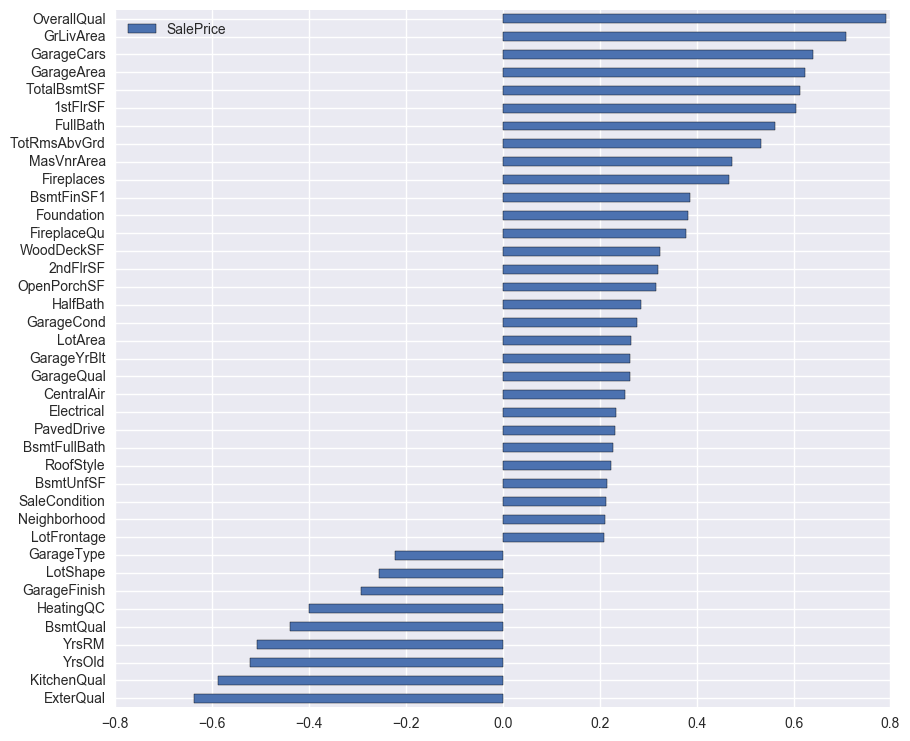

In [4]:
#..............................................
# ----------- Exploration --------------------
#..............................................


df = htrain.sort_index(axis=1,ascending=True)
plt.rcParams['figure.figsize']=(10,9)
#...............................................................
#     ----------- Correlation Plot -----------
#...............................................................
 
corrdf = trNum.corr()
ycorr = corrdf[['SalePrice']]
#ycorr = ycorr.sort_index(axis=0,ascending=False)
ycorr = ycorr.sort_values(by=['SalePrice'])
top_ycorr = ycorr[ycorr.SalePrice.abs()>.2]
top_ycorr.drop(['SalePrice']).plot(kind='barh')



In [5]:
#Where correlation of variable to outcome is > .2
top_ycorr.shape

(40, 1)

- <h5> Correlation Amongst Predictors </h5>

As expected, we see strong collinearity across variables concerned with a top-level attribute of the property (i.e. Garage vars, Basement vars).

There is also a healthy lack of multicollinearity across many of the features.  

For future iterations of this project, it would be worthwhile to explore engineering core derived features for these top-level attributes that combine these native features. 


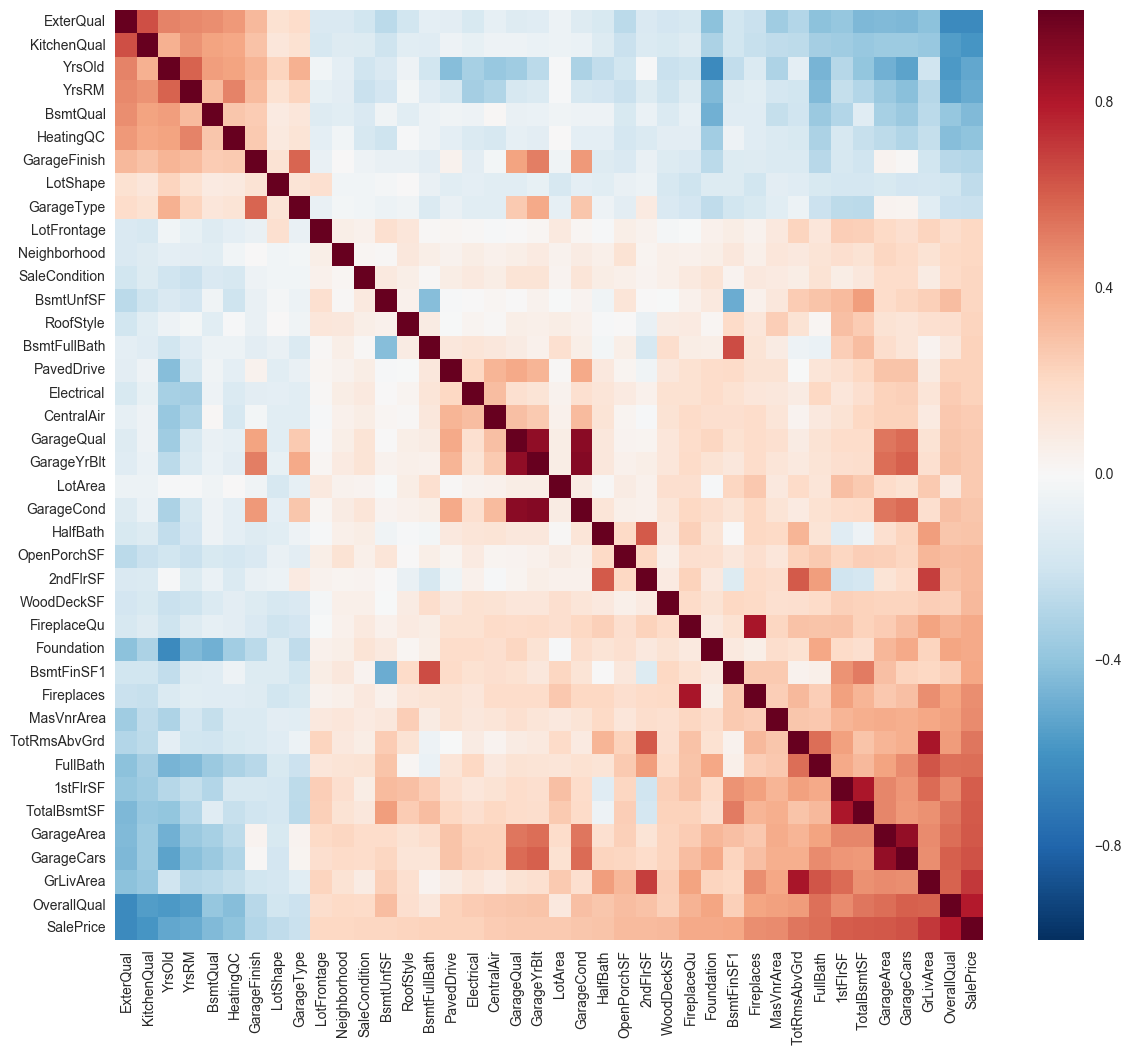

In [6]:
#...............................................................
#     ----------- Plotly - Correlation Heatmap ----------- top correlated
#...............................................................
plt.rcParams['figure.figsize']=(14,12)
top_corrdf = corrdf.sort_index(axis=1,ascending=True).sort_index(axis=0,ascending=True)
#corrdf = corrdf.loc[list(top_ycorr.index)]
sb.heatmap(top_corrdf[list(top_ycorr.index)].loc[list(top_ycorr.index)])

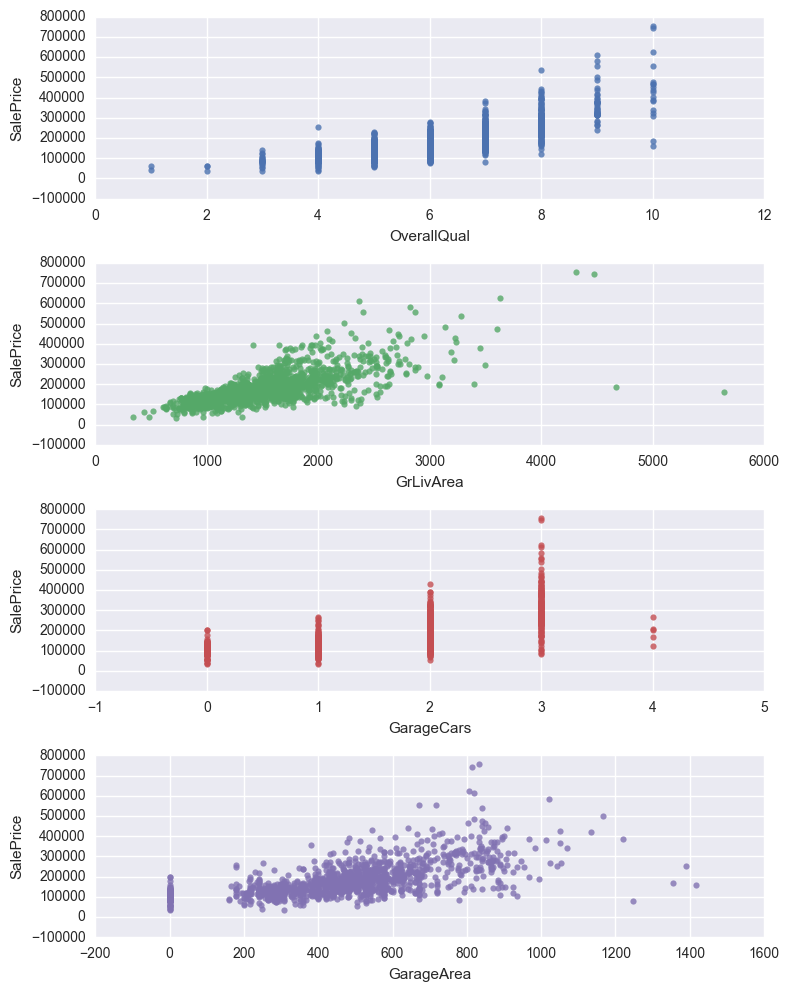

In [134]:
plt.rcParams['figure.figsize']=(8,10)
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
sb.regplot(x='OverallQual', y='SalePrice', data=trNum, fit_reg=False, ax=ax1)
sb.regplot(x='GrLivArea', y='SalePrice', data=trNum, fit_reg=False, ax=ax2)
sb.regplot(x='GarageCars', y='SalePrice', data=trNum, fit_reg=False, ax=ax3)
sb.regplot(x='GarageArea', y='SalePrice', data=trNum, fit_reg=False, ax=ax4)
f.tight_layout()

<h5>Outliers</h5><br>

- Some outliers, like the one below, have a low price for “higher-price” oriented features seemingly captured exclusively in the SaleCondition predictor variable.  

- However, the identifiers for a house like below (‘Partial’) may be associated with higher variability in associated outcome value, thus simply relying on this variable for an accurate quantitative outcome may not be fruitful. <br>

In [135]:
htrain[(htrain.GrLivArea ==  5642)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YrsOld,YrsRM,YrsSS,TotalSF
1298,60,RL,313.0,63887,Pave,0,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,0,0,0,1,New,Partial,160000,9,9,9,11752


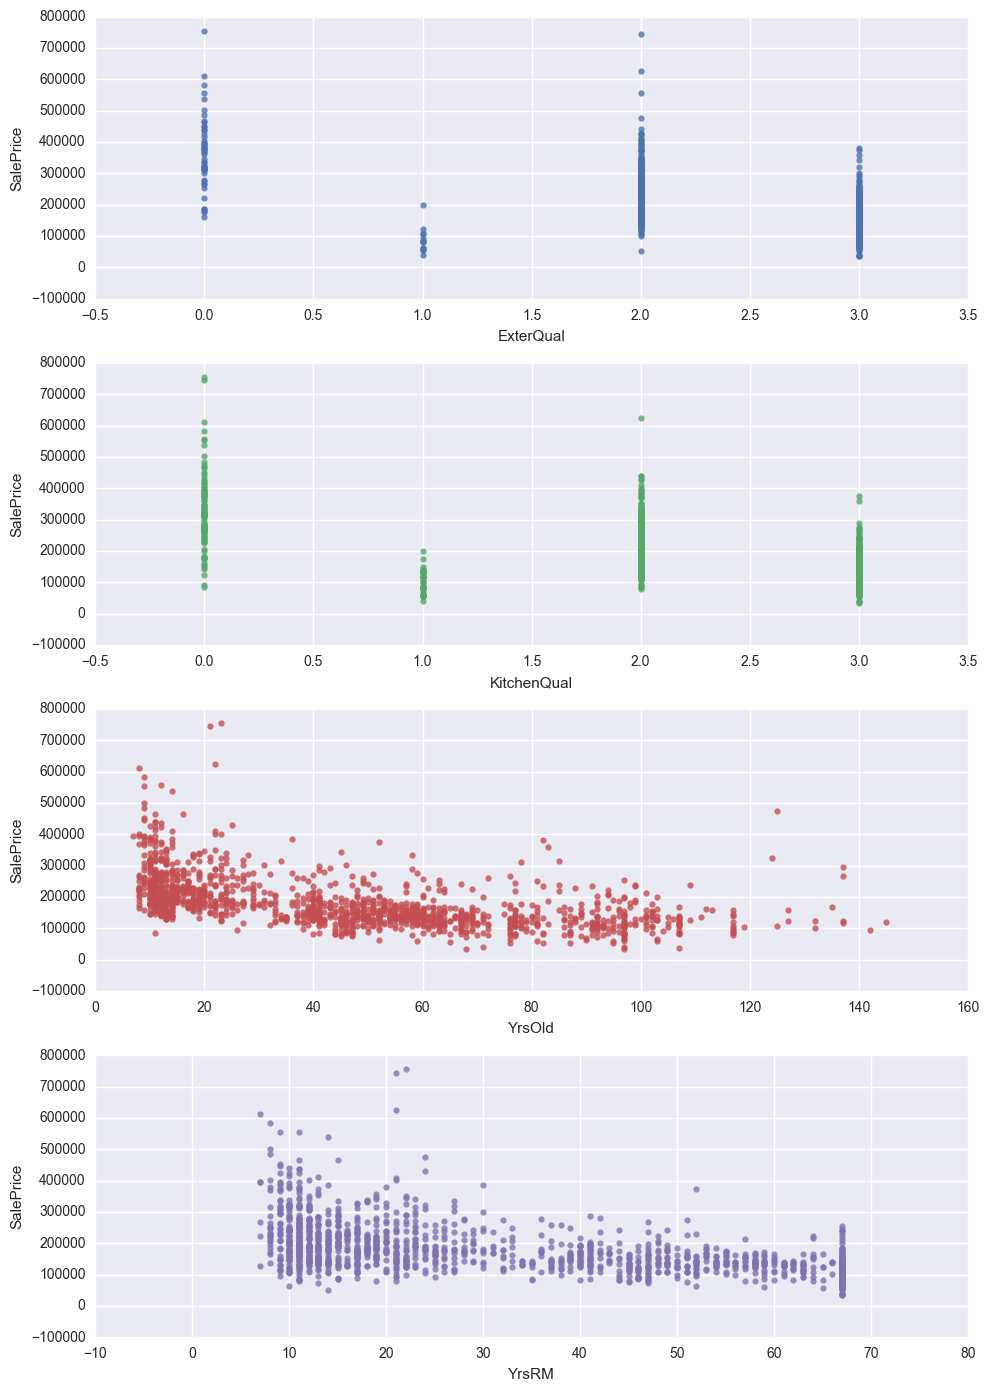

In [16]:
# plt.rcParams['figure.figsize']=(8,10)
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
sb.regplot(x='ExterQual', y='SalePrice', data=trNum, fit_reg=False, ax=ax1)
sb.regplot(x='KitchenQual', y='SalePrice', data=trNum, fit_reg=False, ax=ax2)
sb.regplot(x='YrsOld', y='SalePrice', data=trNum, fit_reg=False, ax=ax3)
sb.regplot(x='YrsRM', y='SalePrice', data=trNum, fit_reg=False, ax=ax4)
f.tight_layout()

<h4>- Set Accuracy Benchmark by Modeling with all variables</h4>

In [8]:
train, test = train_test_split(trNum, test_size = .30, random_state = 1010)

# Train outcome and predictors 
y = train.SalePrice
X = train.drop('SalePrice', axis=1)

# Test outcome and predictors
yt = test.SalePrice
Xt = test.drop('SalePrice', axis=1)

# Create normalized train and test sets

train, test = train_test_split(trNorm, test_size = .30, random_state = 1010)

ynorm = train.SalePrice
Xnorm = train.drop('SalePrice', axis=1)

ytnorm = test.SalePrice
Xtnorm = test.drop('SalePrice', axis=1)
#Set model parameters
gbfit = GradientBoostingRegressor(n_estimators=250, max_depth=2, loss='ls', random_state=1010)

#Fit model
gbfit.fit(X=X, y=y)

#%% explore GB fit
accuracy = gbfit.score(Xt, yt)
predict = gbfit.predict(Xt)



array([  0.00000000e+00,   1.89641478e-02,   6.87913996e-02,
         6.99492987e-02,   3.06313557e-02,   9.53000240e-03,
         6.80919878e-02,   6.50912502e-03,   1.95875167e-02,
         4.65532992e-02,   1.28531661e-02,   2.27251687e-02,
         1.32012759e-03,   9.30608212e-02,   8.80550067e-03,
         3.27339279e-03,   1.56247572e-02,   6.50805625e-03,
         4.44920766e-03,   1.63076807e-02,   4.03581001e-03,
         1.47501981e-02,   2.66316936e-02,   9.55047618e-03,
         5.86699204e-02,   1.16756292e-02,   1.37920758e-02,
         3.58092350e-03,   7.63230025e-03,   1.85172096e-02,
         1.53895450e-02,   0.00000000e+00,   1.26268634e-02,
         3.63861985e-02,   1.52492432e-02,   6.33896029e-03,
         1.78300879e-02,   0.00000000e+00,   0.00000000e+00,
         1.41860060e-03,   7.63058172e-03,   0.00000000e+00,
         6.70110084e-04,   3.94225808e-03,   3.94497564e-02,
         1.71112880e-02,   0.00000000e+00,   0.00000000e+00,
         7.24270739e-03,

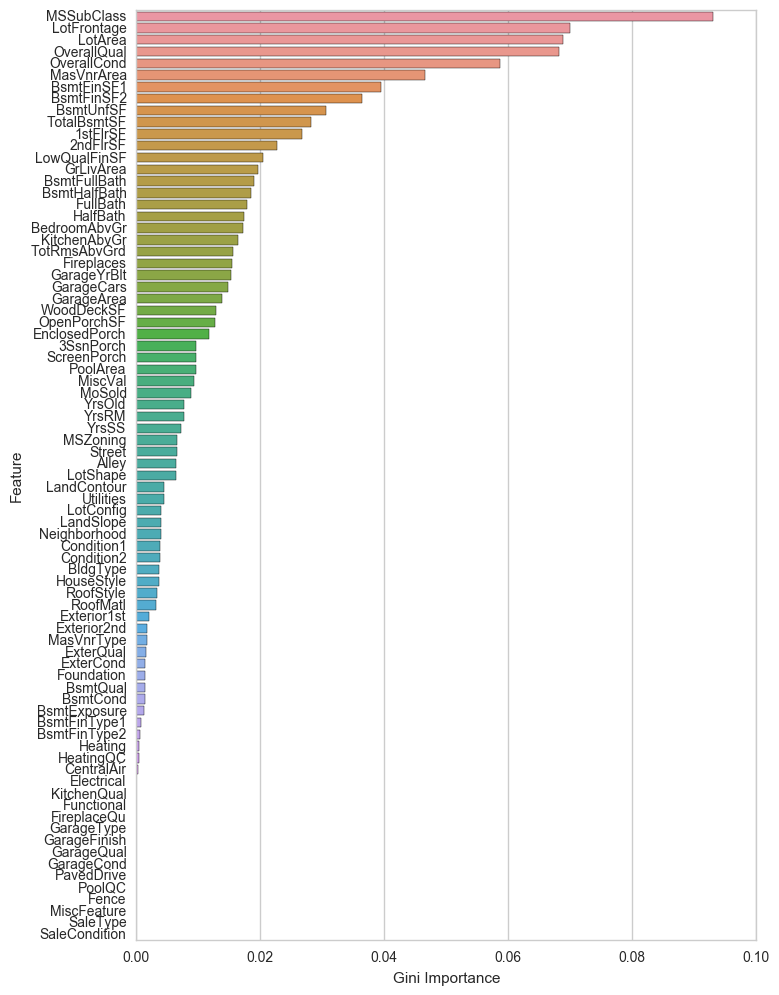

In [9]:
#%% 
# Model feature importances ranking
importances = gbfit.feature_importances_
indices = np.argsort(importances)[::-1]


feat_imp = pd.DataFrame({'Feature':list(X),
                         'Gini Importance':importances[indices]})
plt.rcParams['figure.figsize']=(8,12)
sb.set_style('whitegrid')
ax = sb.barplot(x='Gini Importance', y='Feature', data=feat_imp)
ax.set(xlabel='Gini Importance')
plt.show()  


## Unsupervised Learning


We define a function below to fit a Spectral Clustering model on the predictors for a given number of n\_clusters and return the resulting cluster labels.  The determined cluster assignment of each record, for the given clustering fit, is then added to the dataset as a new feature. We perform this feature derivation for six different iterations of cluster numbers (6, 10, 12, 14, 18, \& 24).  

### Spectral Clustering

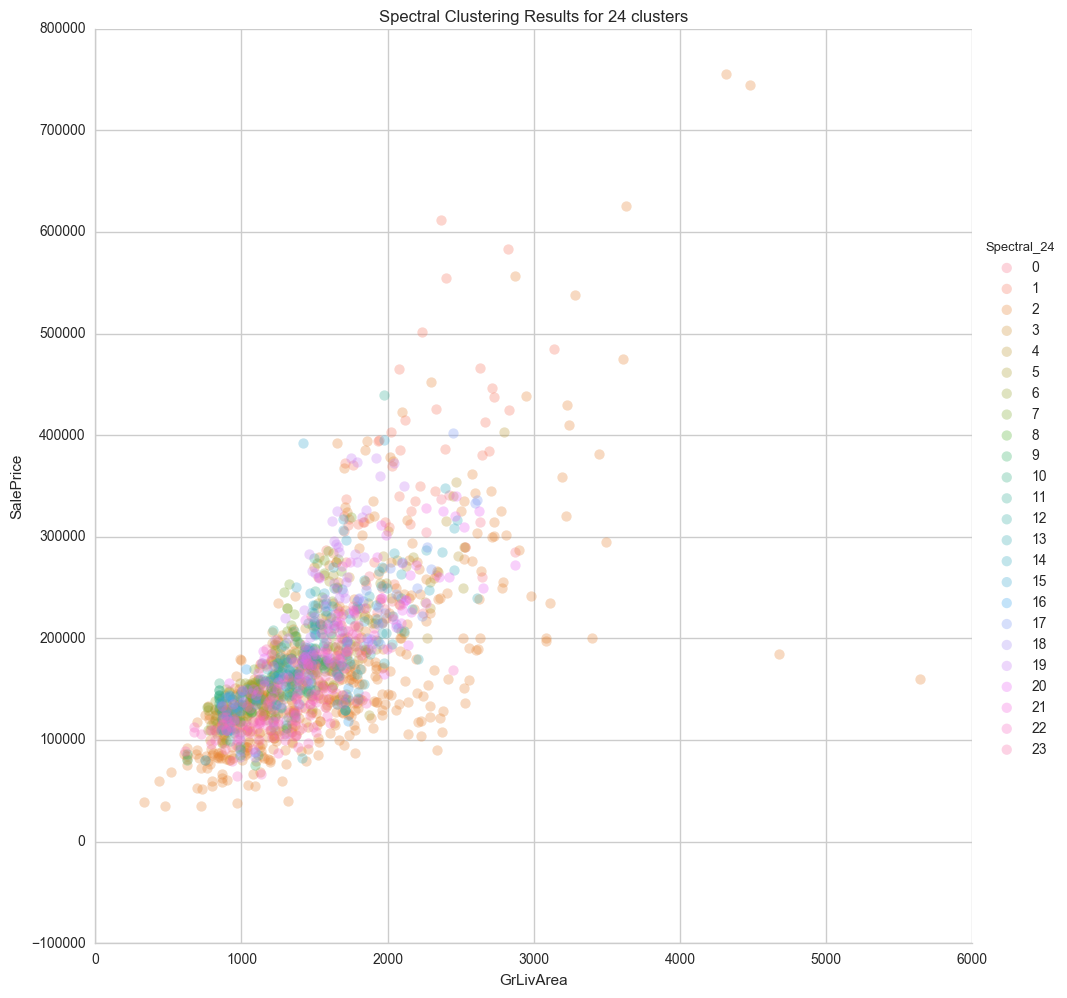

In [10]:
#...................................................................................
#
#                                <Spectral Clustering >
#...................................................................................

#%%
from sklearn.cluster import SpectralClustering

def spectralFeatureAppend(clusters, data):
    sc = SpectralClustering(n_clusters=clusters,
                            eigen_solver='arpack',
                            affinity="rbf")
    sc.fit(np.array(data.drop('SalePrice',axis=1)))
    labels=sc.labels_.astype(np.int)
    return labels
#%%
spec6_labels = spectralFeatureAppend(6, trNorm)
spec10_labels = spectralFeatureAppend(10, trNorm)
spec12_labels = spectralFeatureAppend(12, trNorm)
spec14_labels = spectralFeatureAppend(14, trNorm)
spec18_labels = spectralFeatureAppend(18, trNorm)
spec24_labels = spectralFeatureAppend(24, trNorm)


cData = pd.concat([trNum,
                   pd.Series(spec6_labels, name="Spectral_6"),
                   pd.Series(spec10_labels, name="Spectral_10"),
                   pd.Series(spec12_labels, name="Spectral_12"),
                   pd.Series(spec14_labels, name="Spectral_14"),
                   pd.Series(spec18_labels, name="Spectral_18"),
                   pd.Series(spec24_labels, name="Spectral_24")],axis=1)

#%%
#sb.set(rc={"figure.figsize": (16, 16)})
sb.lmplot("GrLivArea","SalePrice",cData,hue="Spectral_24",
          fit_reg=False,size=10,aspect=1,scatter_kws={"s": 55, 'alpha':0.30})
plt.title('Spectral Clustering Results for 24 clusters')

## Principal Components Analysis

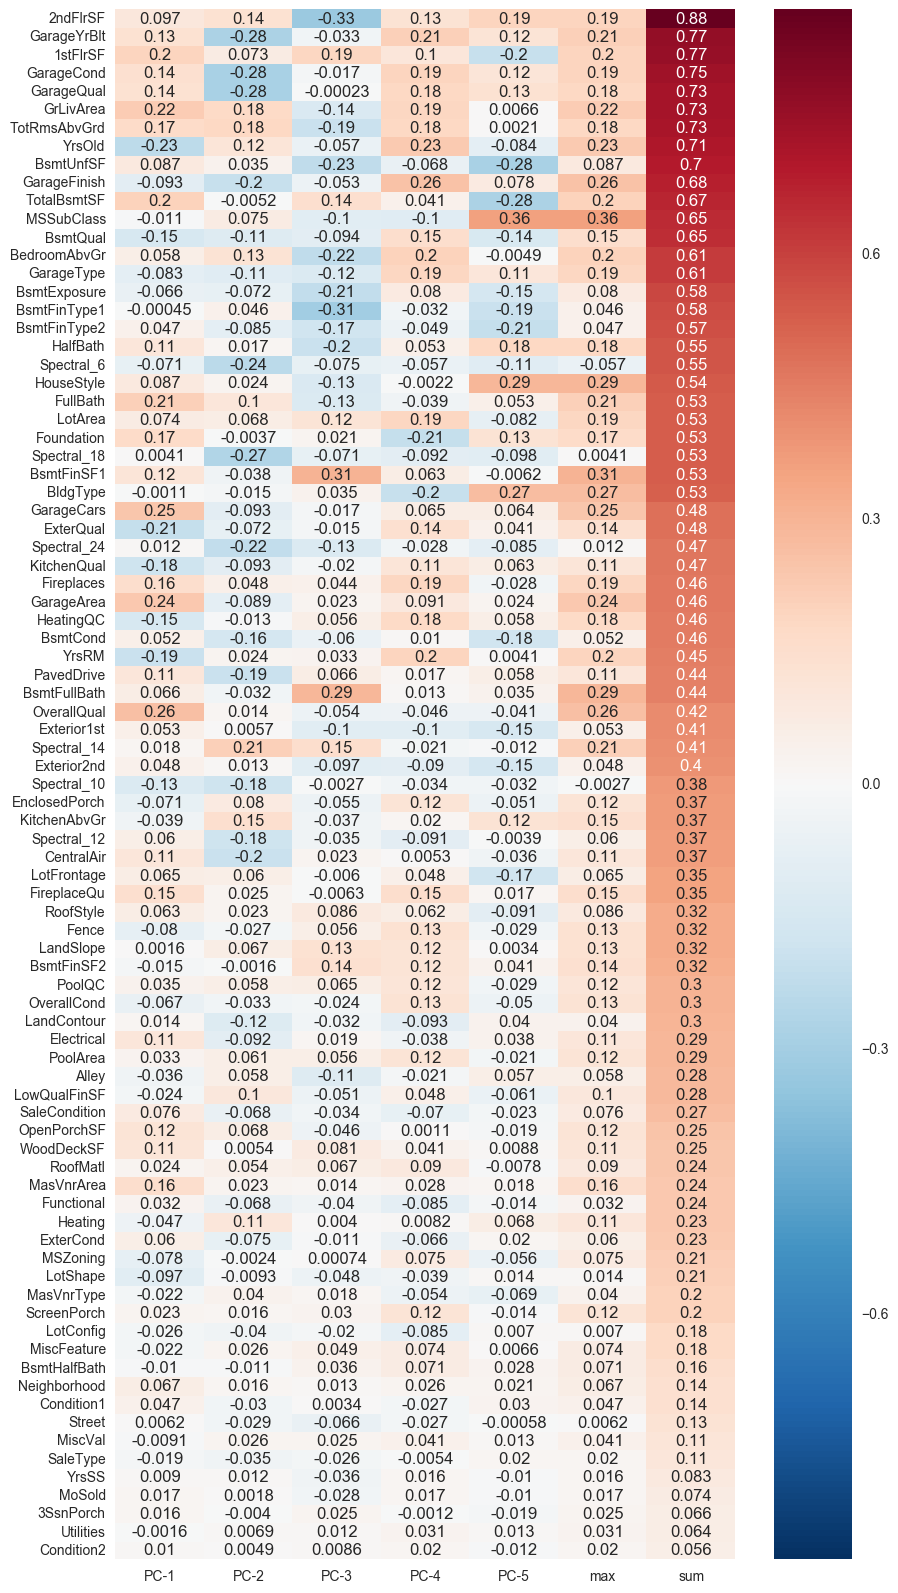

In [11]:
#%%
#-------------------------------------------------------------------
#-------------------------------------------------------------------

#       =========  #PCA  --- Principal Components ========== -------

#-------------------------------------------------------------------
#-------------------------------------------------------------------

#Create a different normalized dataframe for PCA
trPCA = (cData - cData.mean()) / cData.std()
#trPCA = (trNum - trNum.mean()) / trNum.std()
i = np.identity(trPCA.drop('SalePrice', axis=1).shape[1])

pca = PCA(n_components=5, random_state=1010)
pca.fit_transform(trPCA.drop('SalePrice', axis=1).values)

coef = pca.transform(i)
pcp = pd.DataFrame(coef, columns = ['PC-1','PC-2','PC-3','PC-4','PC-5'],
                           index = trPCA.drop('SalePrice', axis=1).columns)

pcp['max'] = pcp.max(axis=1)
pcp['sum'] = pcp.drop('max',axis=1).abs().sum(axis=1)

pcp = pcp.sort_values(by=['sum'], ascending=False)

plt.rcParams['figure.figsize']=(10,20)
sb.heatmap(pcp, annot=True, annot_kws={"size": 12})


<h4> Model Training accounting for top 75 PCA ranked features </h4>

As expected, we see strong collinearity across variables concerned with a top-level attribute of the property (i.e. Garage vars, Basement vars).

There is also a healthy lack of multicollinearity across many of the features.  

For future iterations of this project, it would be worthwhile to explore engineering core derived features for these top-level attributes that combine these native features. 


In [20]:
#%%
#<> ----  Create new train and test sets based on top principal components ---
#<><>
#<><><>
#<><><><>

# -----  -----  save top components

#conditional top
#top = list(pcp[(pcp['max'] > pcp['max'].mean())].index)

#sorted list
pclist = list(pcp.index)
#Set up training and test sets
trNorm = (cData - cData.mean()) / (cData.max() - cData.min())
pcdata = pd.concat([cData[pclist[0:75]],cData['SalePrice']],axis=1)
nmdata = pd.concat([trNorm[pclist[0:75]],trNorm['SalePrice']],axis=1)
#nmonly = pd.concat([trNum_norm[list(numht.drop('SalePrice',axis=1))],trNum_norm['SalePrice']],axis=1)

train, test = train_test_split(pcdata, test_size = .30, random_state = 1010)

# Train outcome and predictors 
y = train.SalePrice
X = train.drop('SalePrice', axis=1)
# Test outcome and predictors
yt = test.SalePrice
Xt = test.drop('SalePrice', axis=1)

# Create normalized train and test sets
train, test = train_test_split(nmdata, test_size = .30, random_state = 1010)
#Norm train
ynorm = train.SalePrice
Xnorm = train.drop('SalePrice', axis=1)
#Norm test
ytnorm = test.SalePrice
Xtnorm = test.drop('SalePrice', axis=1)



In [21]:
#%%
#               ## ==== Model Training ==== ##
#
#               ## ==== Gradient Boosting Regressor ==== ##

#-----------------------------------------------------------------
#Set model parameters
gbfit = GradientBoostingRegressor(n_estimators=250, loss='ls', random_state=1010)

#Fit model
gbfit.fit(X=X, y=y)

#%% explore GB fit
accuracy = gbfit.score(Xt, yt)
predict = gbfit.predict(Xt)

gbr_results = pd.DataFrame({'Predicted':predict,
                            'Ground Truth':yt})

print('Gradient Boosting Accuracy %s' % '{0:.2%}'.format(accuracy))    
# Cross_Validation
v = cross_val_score(gbfit, X, y, cv=10)
for i in range(10):
    print('Cross Validation Score: %s'%'{0:.2%}'.format(v[i,]))

Gradient Boosting Accuracy 91.03%
Cross Validation Score: 93.34%
Cross Validation Score: 89.88%
Cross Validation Score: 90.17%
Cross Validation Score: 88.34%
Cross Validation Score: 88.00%
Cross Validation Score: 88.73%
Cross Validation Score: 90.28%
Cross Validation Score: 81.48%
Cross Validation Score: 88.86%
Cross Validation Score: 54.83%


- <h5> Random Forest Regressor </h5>

In [16]:
#%%
#               ## ==== Model Training ==== ##
#
#               ## ==== Random Forest Regressor ==== ##
rf_fit = RandomForestRegressor(n_estimators=250)
rf_fit.fit(X=Xnorm,y=ynorm)

rf_accuracy = rf_fit.score(Xtnorm, ytnorm)
print('Random Forest Regressor Accuracy %s' % '{0:.2%}'.format(rf_accuracy))    
# Cross_Validation
v = cross_val_score(rf_fit, X, y, cv=10)
for i in range(10):
    print('Cross Validation Score: %s'%'{0:.2%}'.format(v[i,]))

Random Forest Regressor Accuracy 89.65%
Cross Validation Score: 92.77%
Cross Validation Score: 92.37%
Cross Validation Score: 87.45%
Cross Validation Score: 75.95%
Cross Validation Score: 90.24%
Cross Validation Score: 87.91%
Cross Validation Score: 84.26%
Cross Validation Score: 80.81%
Cross Validation Score: 85.95%
Cross Validation Score: 65.21%


- <h5> Lasso Regression </h5>

Our Lasso score is even lower with not only greater variability in out-of-sample error, but also a much lower initial accuracy. 

In [127]:
#%%
#               ## ==== Model Training - Lasso ==== ##
#%%#   ------- Linear Models --------

reg = linear_model.Lasso(alpha=4, max_iter=2500)
reg.fit(X,y)
accuracy = reg.score(Xt,yt)

print('Lasso Accuracy %s' % '{0:.2%}'.format(accuracy)) 
# Cross_Validation
v = cross_val_score(reg, X, y, cv=10)
for i in range(10):
    print('Cross Validation Score: %s'%'{0:.2%}'.format(v[i,]))

Lasso Accuracy 85.24%
Cross Validation Score: 87.02%
Cross Validation Score: 89.98%
Cross Validation Score: 81.61%
Cross Validation Score: 51.73%
Cross Validation Score: 88.21%
Cross Validation Score: 89.07%
Cross Validation Score: 91.46%
Cross Validation Score: 81.85%
Cross Validation Score: 69.02%
Cross Validation Score: 55.20%


- <h5> MLP Regressor </h5>

In [17]:

mlpreg = MLPRegressor(solver='lbfgs', alpha=.5, hidden_layer_sizes=(100,), random_state=10)
mlpRfit = mlpreg.fit(Xnorm, ynorm)
mlpRaccuracy = mlpRfit.score(Xtnorm, ytnorm)

print('MLP Regression Accuracy %s' % '{0:.2%}'.format(mlpRaccuracy))    
# Cross_Validation
v = cross_val_score(mlpRfit, X, y, cv=10)
for i in range(10):
    print('Cross Validation Score: %s'%'{0:.2%}'.format(v[i,]))

MLP Regression Accuracy 91.10%
Cross Validation Score: 78.88%
Cross Validation Score: 80.95%
Cross Validation Score: 67.21%
Cross Validation Score: 35.83%
Cross Validation Score: 77.06%
Cross Validation Score: 71.44%
Cross Validation Score: 76.15%
Cross Validation Score: 61.70%
Cross Validation Score: 61.55%
Cross Validation Score: 56.00%


<hr></h2>**Classification Models**</h2>

In [14]:
  #%%
# -------------- Create Bins for SalesPrice Variable --------------------
# ...
## ... for use with Classification Models


#bins = [0,100000,150000,200000,250000,300000,350000,400000,
##       450000,500000,550000,600000,650000,700000]

# .. need to create labels vector for 'mix type error (string and num)

bins=7
cData['PriceRange'] = pd.cut(cData.SalePrice, bins)
cData['PriceRange'] = pd.cut(cData.SalePrice, bins)

#%%
#Set up training and test sets for classification

#cats = pd.concat([trNum_norm,trNum_norm['PriceRange']],axis=1)
cats = cData.drop('SalePrice',axis=1)
train, test = train_test_split(cats, test_size = .25, random_state=10)

# Train outcome and predictors 
y = train.PriceRange
X = train.drop('PriceRange', axis=1)

# Test outcome and predictors
yt = test.PriceRange
Xt = test.drop('PriceRange', axis=1)

cData.PriceRange.value_counts()


(137771.429, 240642.857]    751
(34179.9, 137771.429]       464
(240642.857, 343514.286]    186
(343514.286, 446385.714]     45
(446385.714, 549257.143]      7
(549257.143, 652128.571]      5
(652128.571, 755000]          2
Name: PriceRange, dtype: int64

In [15]:

forest = RandomForestClassifier(n_estimators=1000, random_state=1010)
rfit = forest.fit(X,y)
rfc_accuracy = rfit.score(Xt,yt)


print('Random Forest Classifier %s' % '{0:.2%}'.format(rfc_accuracy))    
# Cross_Validation
v = cross_val_score(rfit, X, y, cv=10)
for i in range(10):
    print('Cross Validation Score: %s'%'{0:.2%}'.format(v[i,]))

Random Forest Classifier 83.56%


/Users/NNK/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.



Cross Validation Score: 76.99%
Cross Validation Score: 86.73%
Cross Validation Score: 75.89%
Cross Validation Score: 79.09%
Cross Validation Score: 82.57%
Cross Validation Score: 77.78%
Cross Validation Score: 81.48%
Cross Validation Score: 89.81%
Cross Validation Score: 84.11%
Cross Validation Score: 83.18%


<h3> Conclusions and Remarks for Future Research </h3>

- Dimensionality reduction with PCA does not yield us greater accuracy, we should turn to advanced feature engineering.
<br><br>
    - Try with dummy variables while being aware of overfitting and test set distinction. 
    - Derive features to represent core property attributes (Bsmnt, Garage)
    - Ensemble methods for Feature Extraction.
    - Address outliers.
<br><br>
- Exploring a combination of predictor models (GBR, Lasso, Ridge, SGDR, ElasticNet) for greater accuracy rather than relying on one model alone.
<br><br>
- Derive or acquire more dimensionality on features regarding the transaction itself. 
